In [76]:
from functools import partial
import os

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

from mne.datasets import sample
from mne.io import read_raw_fif
from mne import make_fixed_length_epochs

from pyriemann.estimation import Covariances
from pyriemann.clustering import Potato
from pyriemann.utils.viz import _add_alpha
from pyriemann.utils.covariance import normalize

In [77]:
from filenames_and_paths import *
import mne

# raw_fname = os.path.join(sample.data_path(), 'MEG', 'sample',
#                          'sample_audvis_filt-0-40_raw.fif')
# raw = read_raw_fif(raw_fname, preload=True, verbose=False)

raw = mne.io.read_raw_brainvision(folders.raw_data + path014 + filenames014[0] + '.vhdr', preload=True)
raw = raw.drop_channels(["EOG", "BIP1", "M1", "M2", "PO5", "PO6"])
raw.set_montage(mne.channels.make_standard_montage("biosemi64"))

raw_clean = mne.io.read_raw_eeglab(folders.preprocessed_data + path014 + filenames014[0] + '.set', preload=True)
raw_clean = raw_clean.drop_channels(["PO5", "PO6"])


sfreq = int(raw.info['sfreq']) 

Extracting parameters from ./raw_data/rest_14/ACP_INP0014_REST1_1pnt_1vis.vhdr...
Setting channel info structure...
Reading 0 ... 1013446  =      0.000 ...   494.847 secs...


C:\Users\bortn\AppData\Local\Temp\ipykernel_7720\711503744.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_clean = mne.io.read_raw_eeglab(folders.preprocessed_data + path014 + filenames014[0] + '.set', preload=True)


In [78]:
ch_names = "Fp1"

# Apply band-pass filter between 1 and 35 Hz
raw.filter(1, 40, n_jobs=-1)
raw.set_eeg_reference(ref_channels='average', projection=True)
# raw_clean.filter(1, 20)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


[Parallel(n_jobs=-1)]: Done  52 out of  59 | elapsed:    2.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    2.6s finished


<RawBrainVision | ACP_INP0014_REST1_1pnt_1vis.eeg, 59 x 1013447 (494.8 s), ~456.3 MB, data loaded>

In [79]:
# Epoch time-series with a sliding window
duration = 2.5    # duration of epochs
interval = 0.2    # interval between successive epochs

epochs = make_fixed_length_epochs(
    raw, duration=duration, overlap=duration - interval, verbose=False)
epochs_data = 5e5 * epochs.get_data(copy=False)

clean_epochs = make_fixed_length_epochs(
    raw_clean, duration=duration, overlap=duration - interval, verbose=False)
clean_epochs_data = 5e5 * clean_epochs.get_data(copy=False)

Using data from preloaded Raw for 2462 events and 5120 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 2462 events and 5120 original time points ...
0 bad epochs dropped


In [80]:
data = raw.get_data()

print(data.mean(), data.max(), data.min())

clean_data = raw_clean.get_data()
print(clean_data.mean(), clean_data.max(), clean_data.min())

-3.2654949598502824e-08 0.00039480962567293944 -0.00020860228893322848
-1.1444587470562603e-10 0.00012383875274658203 -0.00010640718078613281


In [81]:
# clean_epochs_data.shape

In [82]:
# scaler = mne.decoding.Scaler(info=raw_clean.info, scalings='mean', with_mean=True, with_std=True)
# clean_scaled_epochs_data = scaler.fit_transform(clean_epochs_data)

In [83]:
# print(clean_scaled_epochs_data.mean(), clean_scaled_epochs_data.max(), clean_scaled_epochs_data.min())

In [84]:
# scaled_epochs_data = scaler.fit_transform(epochs_data)

In [85]:
# print(scaled_epochs_data.mean(), scaled_epochs_data.max(), scaled_epochs_data.min())

In [281]:
# Estimate spatial covariance matrices
covs = Covariances(estimator='lwf').transform(epochs_data)
clean_covs = Covariances(estimator='lwf').transform(clean_epochs_data)
# covs = normalize(Covariances(estimator='lwf').transform(clean_scaled_epochs_data), 'trace')
# covs = normalize(Covariances(estimator='lwf').transform(epochs_data), 'trace')
# clean_covs = normalize(Covariances(estimator='lwf').transform(scaled_epochs_data), 'trace')
# clean_covs = normalize(Covariances(estimator='lwf').transform(clean_epochs_data), 'trace')

In [282]:
print(covs.mean(), covs.max(), covs.min())
print(clean_covs.mean(), clean_covs.max(), clean_covs.min())

0.0008020659445946255 2576.104145113312 -654.0110783545438
0.0189662057519854 721.1730994267772 -314.124518806575


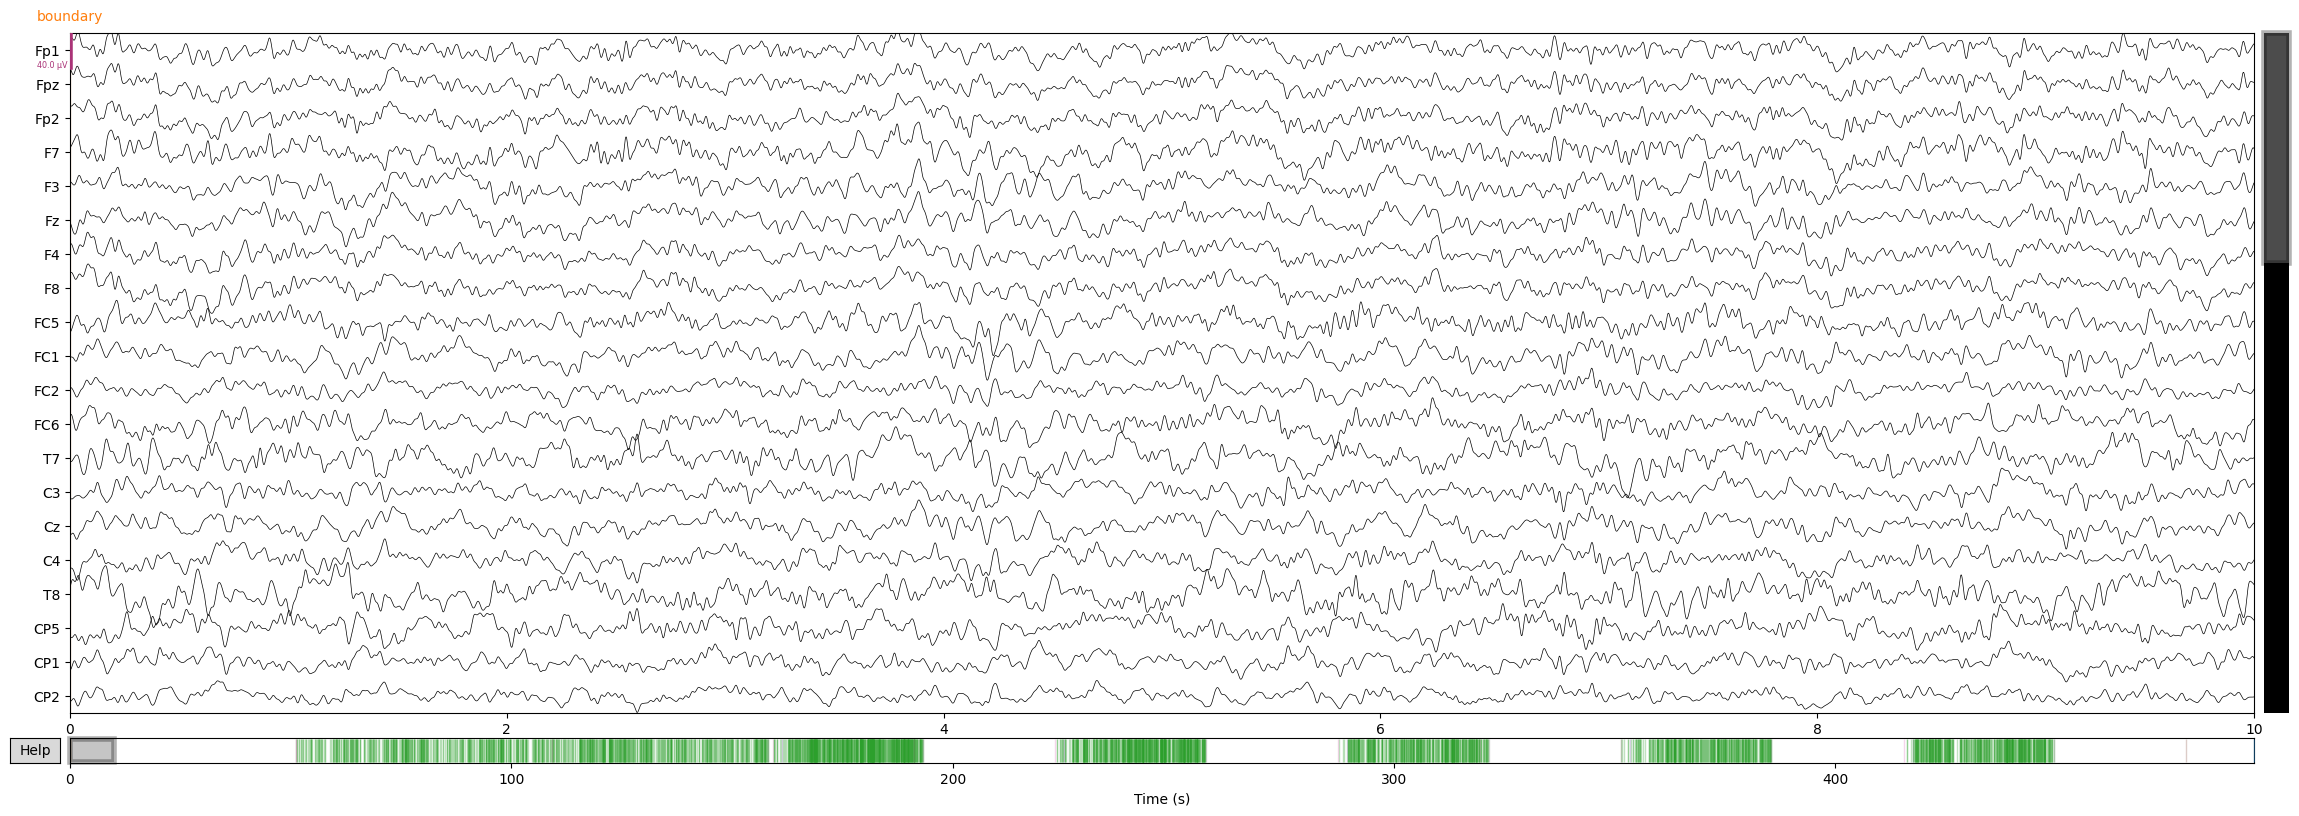

In [105]:
%matplotlib qt
# raw.plot()
# raw_clean.plot()

In [89]:
%matplotlib inline

In [90]:
# print(covs.shape, clean_covs.shape)

In [91]:
z_th = 2 #4.65      # z-score threshold


In [92]:
# Calibrate potato by unsupervised training on first matrices: compute a
# reference matrix, mean and standard deviation of distances to this reference.
train_covs = 500  # nb of matrices to train the potato
train_set = range(train_covs)
train_dataset = clean_covs[train_set]
rpotato = Potato(metric='riemann', threshold=z_th).fit(train_dataset)
# epotato = Potato(metric='euclid', threshold=z_th).fit(clean_covs[train_set])


In [93]:
rpotato.set_params(threshold=3)

Potato()

In [94]:
# train_transformed = rpotato.fit_transform(train_dataset)

rp_labels = rpotato.predict(clean_covs[train_set])
rp_proba = rpotato.predict_proba(clean_covs[train_set])
print(np.unique(rp_labels, return_counts=True))


(array([0., 1.]), array([ 50, 450], dtype=int64))


In [95]:
test_set = range(500)
test_dataset = covs[test_set]

test_transformed = rpotato.transform(test_dataset)

rp_labels_test = rpotato.predict(covs[test_set])
rp_proba_test = rpotato.predict_proba(covs[test_set])
print(np.unique(rp_labels_test, return_counts=True))

(array([0.]), array([500], dtype=int64))


In [96]:
# print(train_transformed.mean(), train_transformed.max(), train_transformed.min())
# print(test_transformed.mean(), test_transformed.max(), test_transformed.min())
# print(train_transformed.shape, test_transformed.shape)
# print(train_dataset.shape, test_dataset.shape)

In [97]:
X_covs = clean_covs
X_raw = raw_clean
X_epochs = clean_epochs
X_epochs_data = clean_epochs_data

# X_covs = covs
# X_raw = raw
# X_epochs = epochs
# X_epochs_data = epochs_data

(<matplotlib.image.AxesImage at 0x1bea10f8190>,
 <matplotlib.contour.QuadContourSet at 0x1be1d4b0490>)

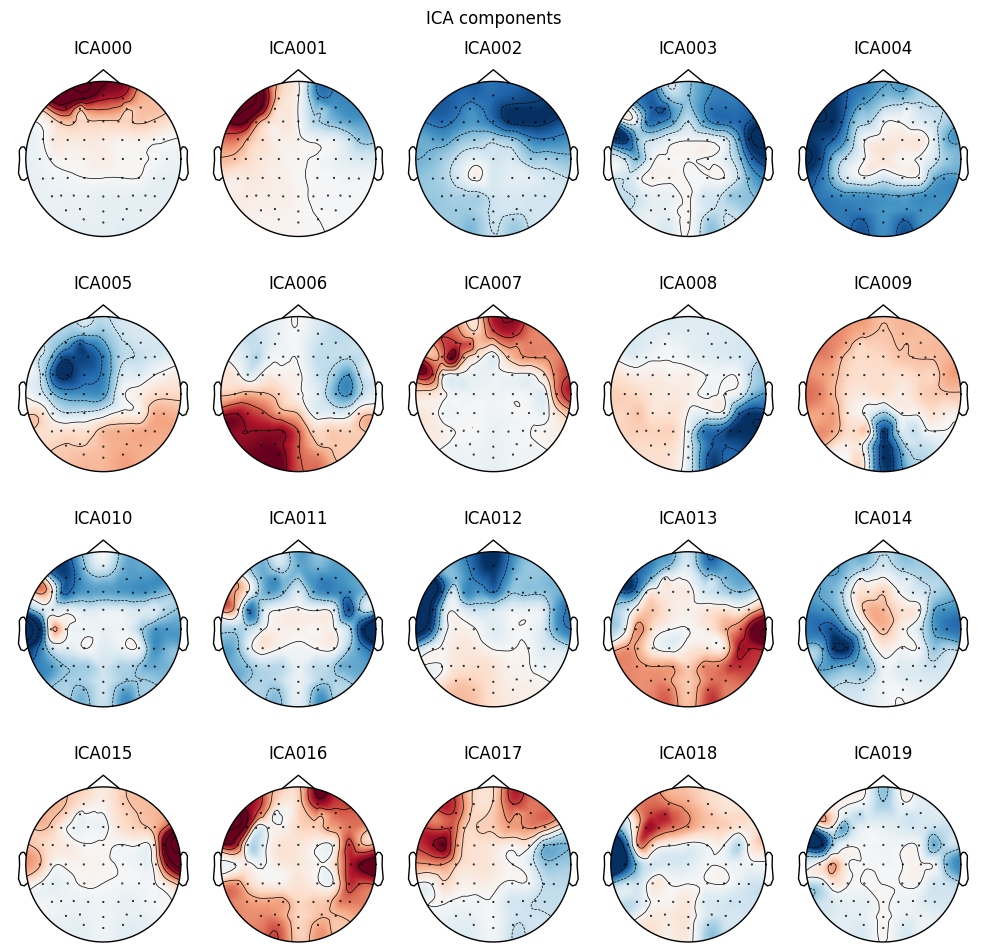

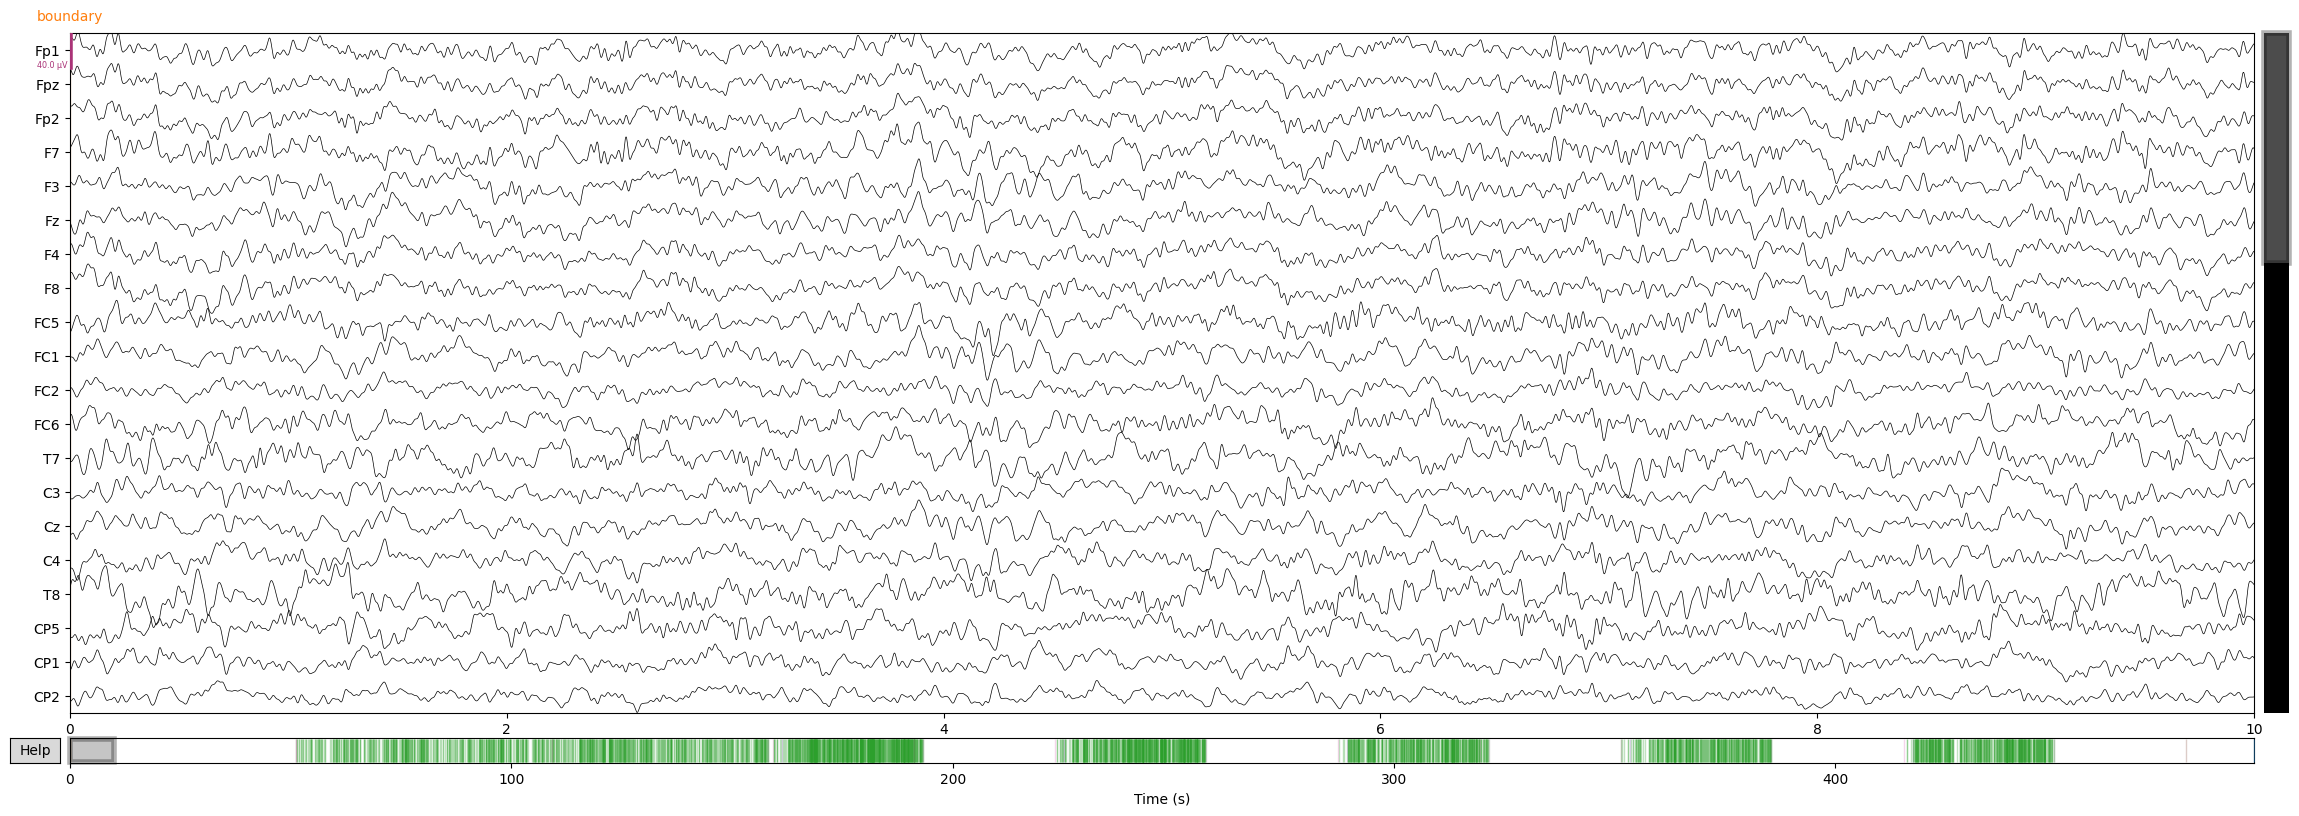

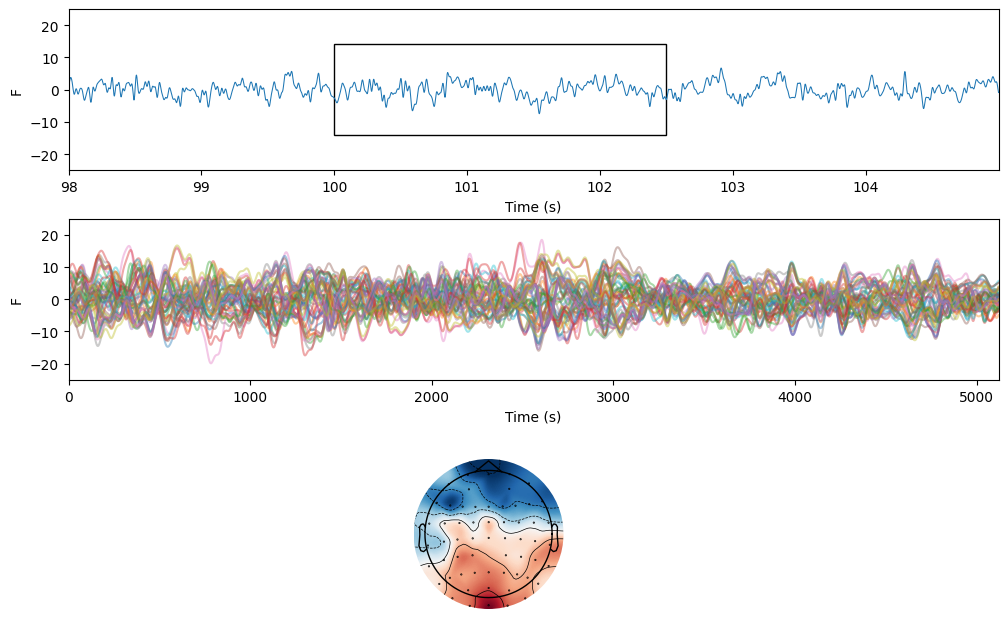

Channels marked as bad:
none


In [98]:
%matplotlib inline
def plot_sig(ax, time, sig):
    ax.axis((time[0], time[-1], -25, 25))
    pl, = ax.plot(time, sig, lw=0.75)
    ax.axhspan(
        -14, 14, edgecolor='k', facecolor='none',
        xmin=xmin,
        xmax=xmax)
    return pl


# Prepare data for online detection
test_covs_max = 600    # nb of matrices to visualize in this example
test_time_start = -2    # start time to display signal
test_time_end = 5       # end time to display signal

time_start = train_covs * interval + test_time_start
time_end = train_covs * interval + test_time_end

xmin = -test_time_start / (test_time_end - test_time_start)
xmax = (duration - test_time_start) / (test_time_end - test_time_start)

# time_start = test_time_start + 1
# time_end = test_time_end + 1 
time = np.linspace(time_start, time_end, int((time_end - time_start) * sfreq),
                   endpoint=False)

eeg_data = 3e5 * X_raw.get_data(picks=ch_names)
sig = eeg_data[:, int(time_start * sfreq):int(time_end * sfreq)]


fig = plt.figure(figsize=(12, 10), constrained_layout=False)
# fig.suptitle('Online artifact detection by potatoes', fontsize=16)
gs = fig.add_gridspec(nrows=4, ncols=40, top=0.90, hspace=0.3, wspace=1.0)
ax_sig0 = fig.add_subplot(gs[0, :], xlabel='Time (s)', ylabel=ch_names[0])
ax_sig1 = fig.add_subplot(gs[1, :], xlabel='Time (s)', ylabel=ch_names[0])
pl_sig0 = plot_sig(ax_sig0, time, sig[0])
text = fig.text(0.5, 0.95, '', ha='center', va='center', fontsize=12)
ax_topo = fig.add_axes([0.4, 0.3, 0.15, 0.15])

analysing_epoch = X_epochs_data[0]
# epoch_topo = fig.add_axes([0.4, 0.55, 0.15, 0.15])
# X_epochs.load_data()
# fig = analysing_epoch.plot(show=False, picks=ch_names)
x_points = range(0, len(analysing_epoch[0]))
ax_sig1.axis((0, len(analysing_epoch[0]), -25, 25))

for ch in analysing_epoch:
    ax_sig1.plot(x_points, ch, alpha=0.4)
# ax_epoch = fig.add_subplot(gs[1, :], xlabel='Time (s)', ylabel='Epoch')
# pl_epoch = plot_sig(ax_epoch, time, analysing_epoch[0])

# full_eeg_data = X_raw.get_data()
mean_eeg_in_axhspan = analysing_epoch.mean(axis=1)
mne.viz.plot_topomap(mean_eeg_in_axhspan, X_raw.info, axes=ax_topo, show=False)

In [99]:

def online_detect(t):
    global time, sig, covs_visu

    # Online artifact detection
    #TODO: проблема с выбором и отображением интервалов хз че такое
    t_window = t#int(t-(np.ceil((duration/interval)*2)))
    # print(t, t_window)
    rp_label = rpotato.predict(X_covs[np.newaxis, t_window])[0]
    rp_proba = rpotato.predict_proba(X_covs[np.newaxis, t_window])[0]
    # if rp_label == 1:
    # rpotato.partial_fit(covs[np.newaxis, t_window], alpha=1 / (t_window))
    time_start = t * interval + test_time_end
    time_end = (t + 1) * interval + test_time_end
    time_ = np.linspace(time_start, time_end, int(interval * sfreq),
                        endpoint=False)
    time = np.r_[time[int(interval * sfreq):], time_]
    
    sig = np.hstack((sig[:, int(interval*sfreq):],
                     eeg_data[:, int(time_start*sfreq):int(time_end*sfreq)]))

    ax_topo.clear()
    # mean_eeg_in_axhspan = full_eeg_data[:, int((time_start-4.5) * sfreq):int((time_start-2.5) * sfreq)]
    # mne.viz.plot_topomap(mean_eeg_in_axhspan.T.mean(axis=0).T, X_raw.info, axes=ax_topo, show=False)


    
    analysing_epoch = X_epochs_data[t]
    ax_sig1.clear()
    ax_sig1.axis((0, len(analysing_epoch[0]), -25, 25))
    for ch in analysing_epoch:
        ax_sig1.plot(x_points, ch, alpha=0.4)

    mean_eeg_in_axhspan = analysing_epoch.mean(axis=1)
    mne.viz.plot_topomap(mean_eeg_in_axhspan, X_raw.info, axes=ax_topo, show=False)
    
    if len(time) != sig.shape[1]:
        sig = sig[:, :-1]
        # print("FIXED")
        # print(time[10:])
        # print(len(time))
        # print(sig.shape)
    pl_sig0.set_data(time, sig[0])
    print(rp_label, rp_proba)
    text.set_text(f'Potato label: {rp_label} - proba: {rp_proba},\n topos - {(time_start-4.5)}\n topoe - {(time_start-2.5)} \n t_actual {t} - {t * interval + test_time_end} \n t_predict {t_window} - {(t_window * interval) + test_time_end}')
    #map proba to different colors
    
    ax_sig0.patches[0].set_edgecolor('k' if rp_label == 1 else 'r')
    pl_sig0.axes.set_xlim(time[0], time[-1])
    return pl_sig0

In [100]:
print(range(1, test_covs_max))

range(1, 600)


In [101]:
# Plot complete visu: a dynamic display is required
%matplotlib inline
plt.show()
potato = FuncAnimation(fig, online_detect,
                       frames=range(0, 300),
                       interval=1, blit=False, repeat=False)
# Plot only 10s, for animated documentation
try:
    from IPython.display import HTML
except ImportError:
    raise ImportError("Install IPython to plot animation in documentation")

plt.rcParams["animation.embed_limit"] = 100
with open("data6.html", "w") as file:
    file.write(HTML(potato.to_jshtml(fps=5, default_mode='loop')).data)

0.0 5.0457416023164114e-12
0.0 5.0457416023164114e-12
0.0 5.530586968038875e-05
0.0 0.00012833663723654798
1.0 0.004389735590536015
1.0 0.012202945822744393
1.0 0.043070202264064106
1.0 0.05548741403796109
1.0 0.1244946771449269
1.0 0.1623023518312232
1.0 0.25232993880841004
1.0 0.16847619642924094
1.0 0.20206387155635863
1.0 0.13667175689379008
1.0 0.22221090151091039
1.0 0.3885790646270276
1.0 0.13037360346937854
1.0 0.0857753011155894
1.0 0.030376268941283424
1.0 0.010212630525887612
1.0 0.059543007371566925
1.0 0.5218285646741124
1.0 0.5247054206398389
1.0 0.6829548603455338
1.0 0.6033138194306071
1.0 0.5580467734357726
1.0 0.43630690314436604
1.0 0.2635284705807117
1.0 0.3926126156138475
1.0 0.21405887288633907
1.0 0.3274525754297555
1.0 0.40225364288378995
1.0 0.47021633096891635
1.0 0.6173829175515462
1.0 0.714659164171481
1.0 0.8435813049930347
1.0 0.7851519065471323
1.0 0.7920674328389288
1.0 0.6562487957656009
1.0 0.6654905838107271
1.0 0.5926353091564969
1.0 0.44020170539063

Animation size has reached 105190911 bytes, exceeding the limit of 104857600.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


1.0 0.03061320532338674
1.0 0.12272694625697866
1.0 0.07031377675907913
1.0 0.3688643217427924
1.0 0.2961635285553589
1.0 0.15357962829584682
1.0 0.22492542764181966
1.0 0.03135671455943989


C:\Users\bortn\AppData\Local\Temp\ipykernel_7720\2505339675.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


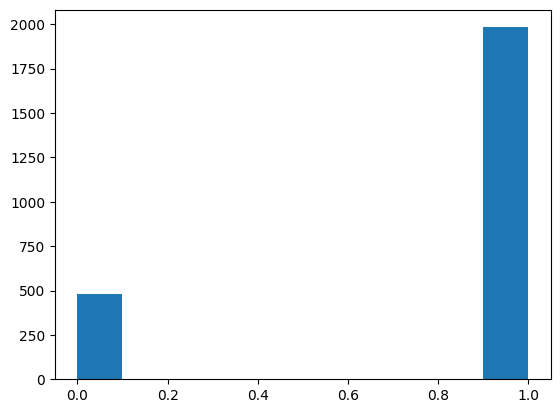

In [114]:
# %matplotlib inline
# rpotato.fit(clean_covs[range(500)])
# vals = rpotato.predict(clean_covs)
# 
# fig, axs = plt.subplots(1, 1)
# 
# axs.hist(vals)
# fig.show()

C:\Users\bortn\AppData\Local\Temp\ipykernel_7720\3699714376.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


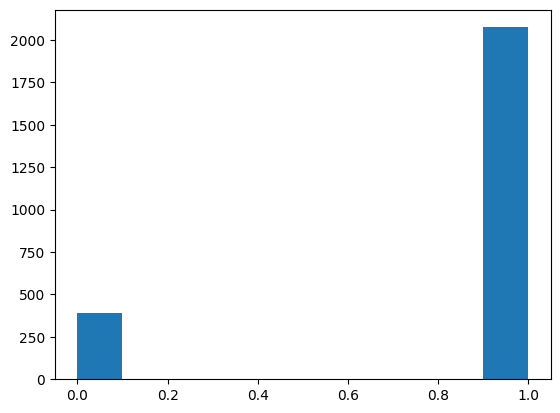

In [118]:
rpotato.fit(covs[range(500)])
vals = rpotato.predict(covs)

fig, axs = plt.subplots(1, 1)

axs.hist(vals)
fig.show()

# ICA

In [253]:
from mne.preprocessing import ICA

ica = ICA(n_components=20, random_state=42, max_iter='auto')
ica.fit(raw)


Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 23.7s.


<ICA | raw data decomposition, method: fastica (fit in 81 iterations on 1013447 samples), 20 ICA components (59 PCA components available), channel types: eeg, no sources marked for exclusion>

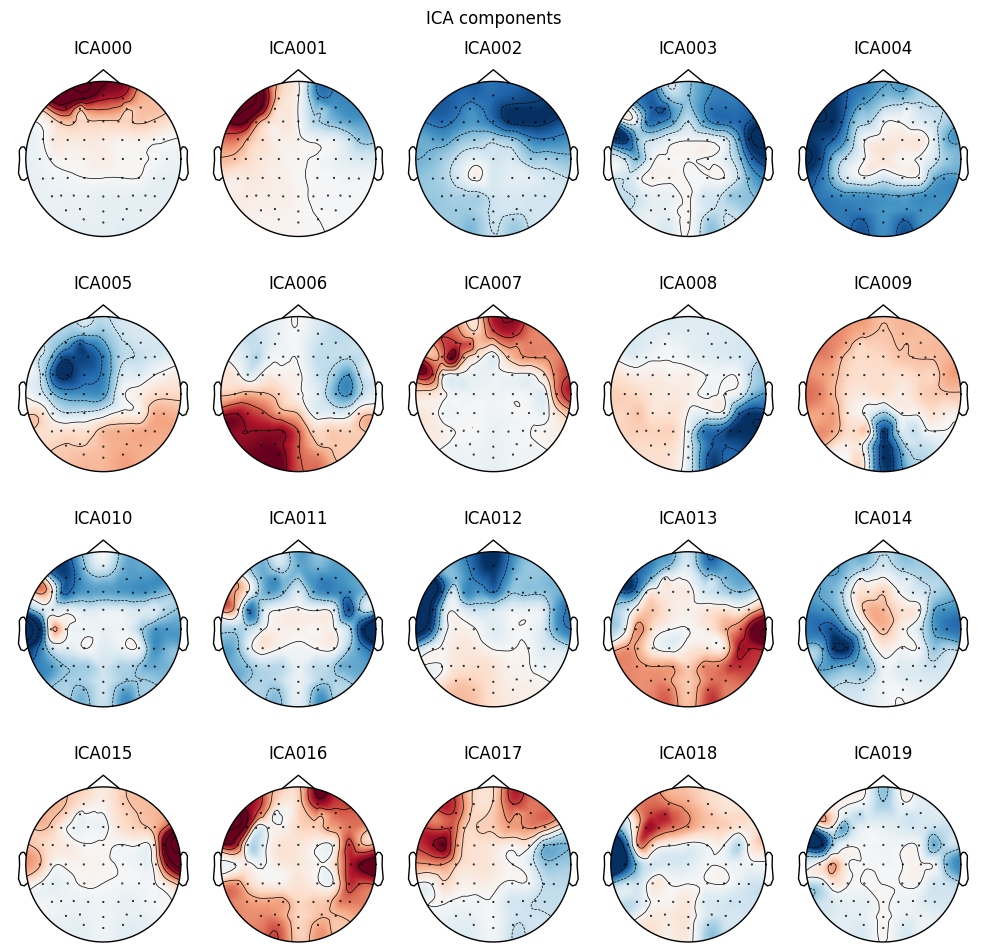

In [254]:
%matplotlib qt
ica.plot_components()

In [268]:
raw_fix = raw.copy()
#0, 1, 12, 15, 16, 18, 19
#0, 1, 2, 7, 10, 11, 15, 17
ica.exclude = [0, 1, 12, 15, 16, 18, 19]
ica.apply(raw_fix)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 7 ICA components
    Projecting back using 59 PCA components


<RawBrainVision | ACP_INP0014_REST1_1pnt_1vis.eeg, 59 x 1013447 (494.8 s), ~456.3 MB, data loaded>

In [269]:
epochs_fix = make_fixed_length_epochs(
    raw_fix, duration=duration, overlap=duration - interval, verbose=False)
epochs_data_fix = 5e5 * epochs_fix.get_data(copy=False)

Using data from preloaded Raw for 2462 events and 5120 original time points ...
0 bad epochs dropped


In [287]:
covs_fix = Covariances(estimator='lwf').transform(epochs_data_fix)

In [290]:
rpotato.set_params(threshold=2)
rpotato.fit(clean_covs[range(500)])

Potato(threshold=2)

In [291]:
print(rpotato.transform(covs_fix).mean())
print(rpotato.transform(covs).mean())
print(rpotato.transform(clean_covs).mean())

34.99079607937121
26.903097825804178
3.4972763879338578


In [292]:
rpotato.set_params(threshold=2)

labels = rpotato.predict(covs)
print(np.unique(labels, return_counts=True))
labels = rpotato.predict(clean_covs)
print(np.unique(labels, return_counts=True))

(array([0.]), array([2462], dtype=int64))
(array([0.]), array([2462], dtype=int64))
(array([0., 1.]), array([1139, 1323], dtype=int64))


In [293]:
rpotato.set_params(threshold=2.5)

rpotato.fit(covs)
labels = rpotato.predict(covs)
print(np.unique(labels, return_counts=True))

rpotato.fit(covs_fix)
labels_fix = rpotato.predict(covs_fix)
print(np.unique(labels_fix, return_counts=True))

rpotato.fit(clean_covs)
labels_clean = rpotato.predict(clean_covs)
print(np.unique(labels_clean, return_counts=True))

(array([0., 1.]), array([ 489, 1973], dtype=int64))
(array([0., 1.]), array([ 545, 1917], dtype=int64))
(array([0., 1.]), array([ 495, 1967], dtype=int64))


In [307]:
mix = np.append(covs[range(500)], clean_covs[range(1000)], axis=0)
# mix = np.append(mix, covs_fix[range(1000)], axis=0)
rpotato.fit(mix)



Potato(threshold=2)

In [308]:
rpotato.set_params(threshold=2)

# labels_mix = rpotato.predict(mix)
# print(np.unique(labels_mix, return_counts=True))
labels = rpotato.predict(covs)
print(np.unique(labels, return_counts=True))
labels_clean = rpotato.predict(clean_covs)
print(np.unique(labels_clean, return_counts=True))
# labels_fix = rpotato.predict(covs_fix)
# print(np.unique(labels_fix, return_counts=True))

print(rpotato.transform(covs).mean())
print(rpotato.transform(clean_covs).mean())
# print(rpotato.transform(covs_fix).mean())

(array([0., 1.]), array([ 478, 1984], dtype=int64))
(array([0., 1.]), array([  57, 2405], dtype=int64))
1.558276007088418
-0.38009944898414155


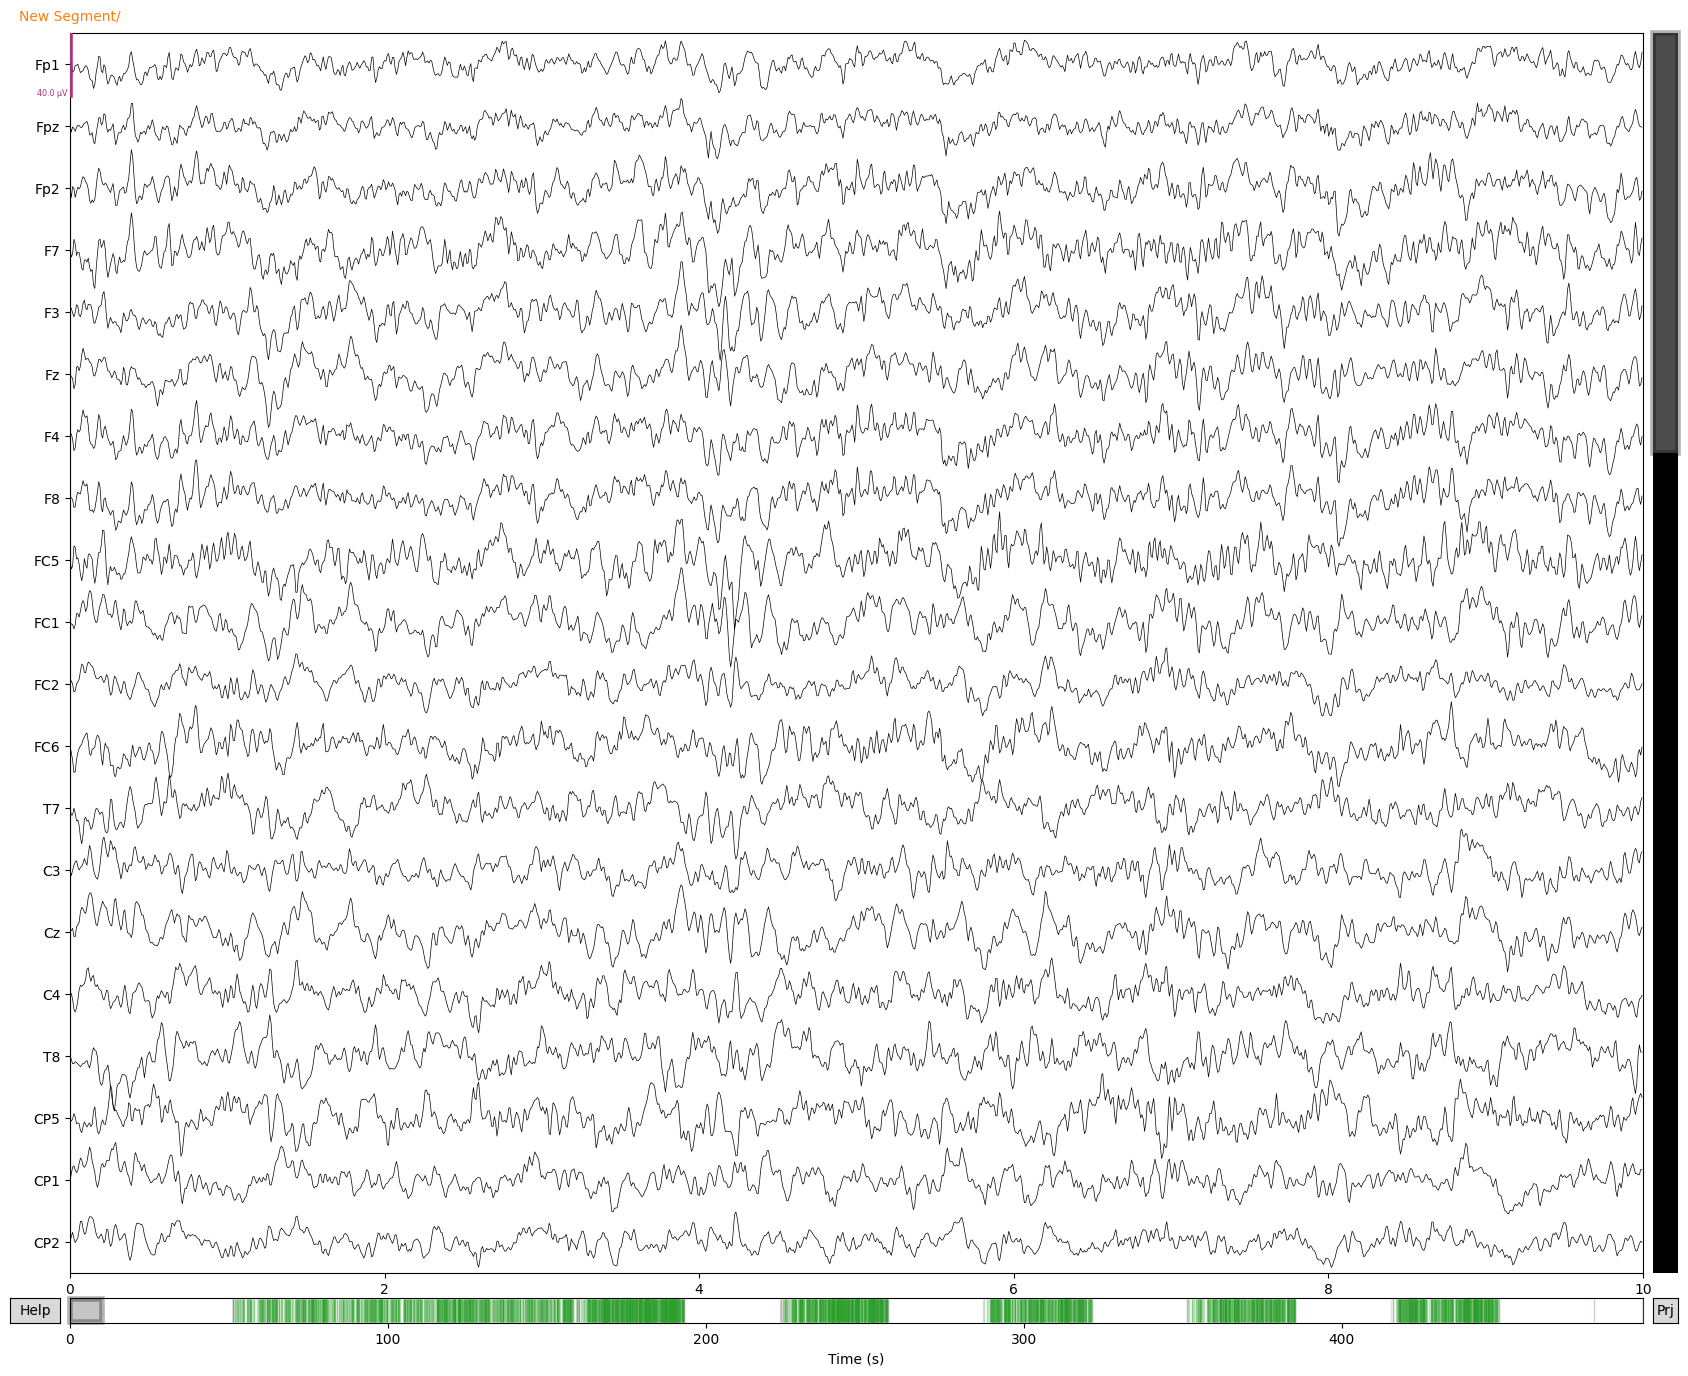

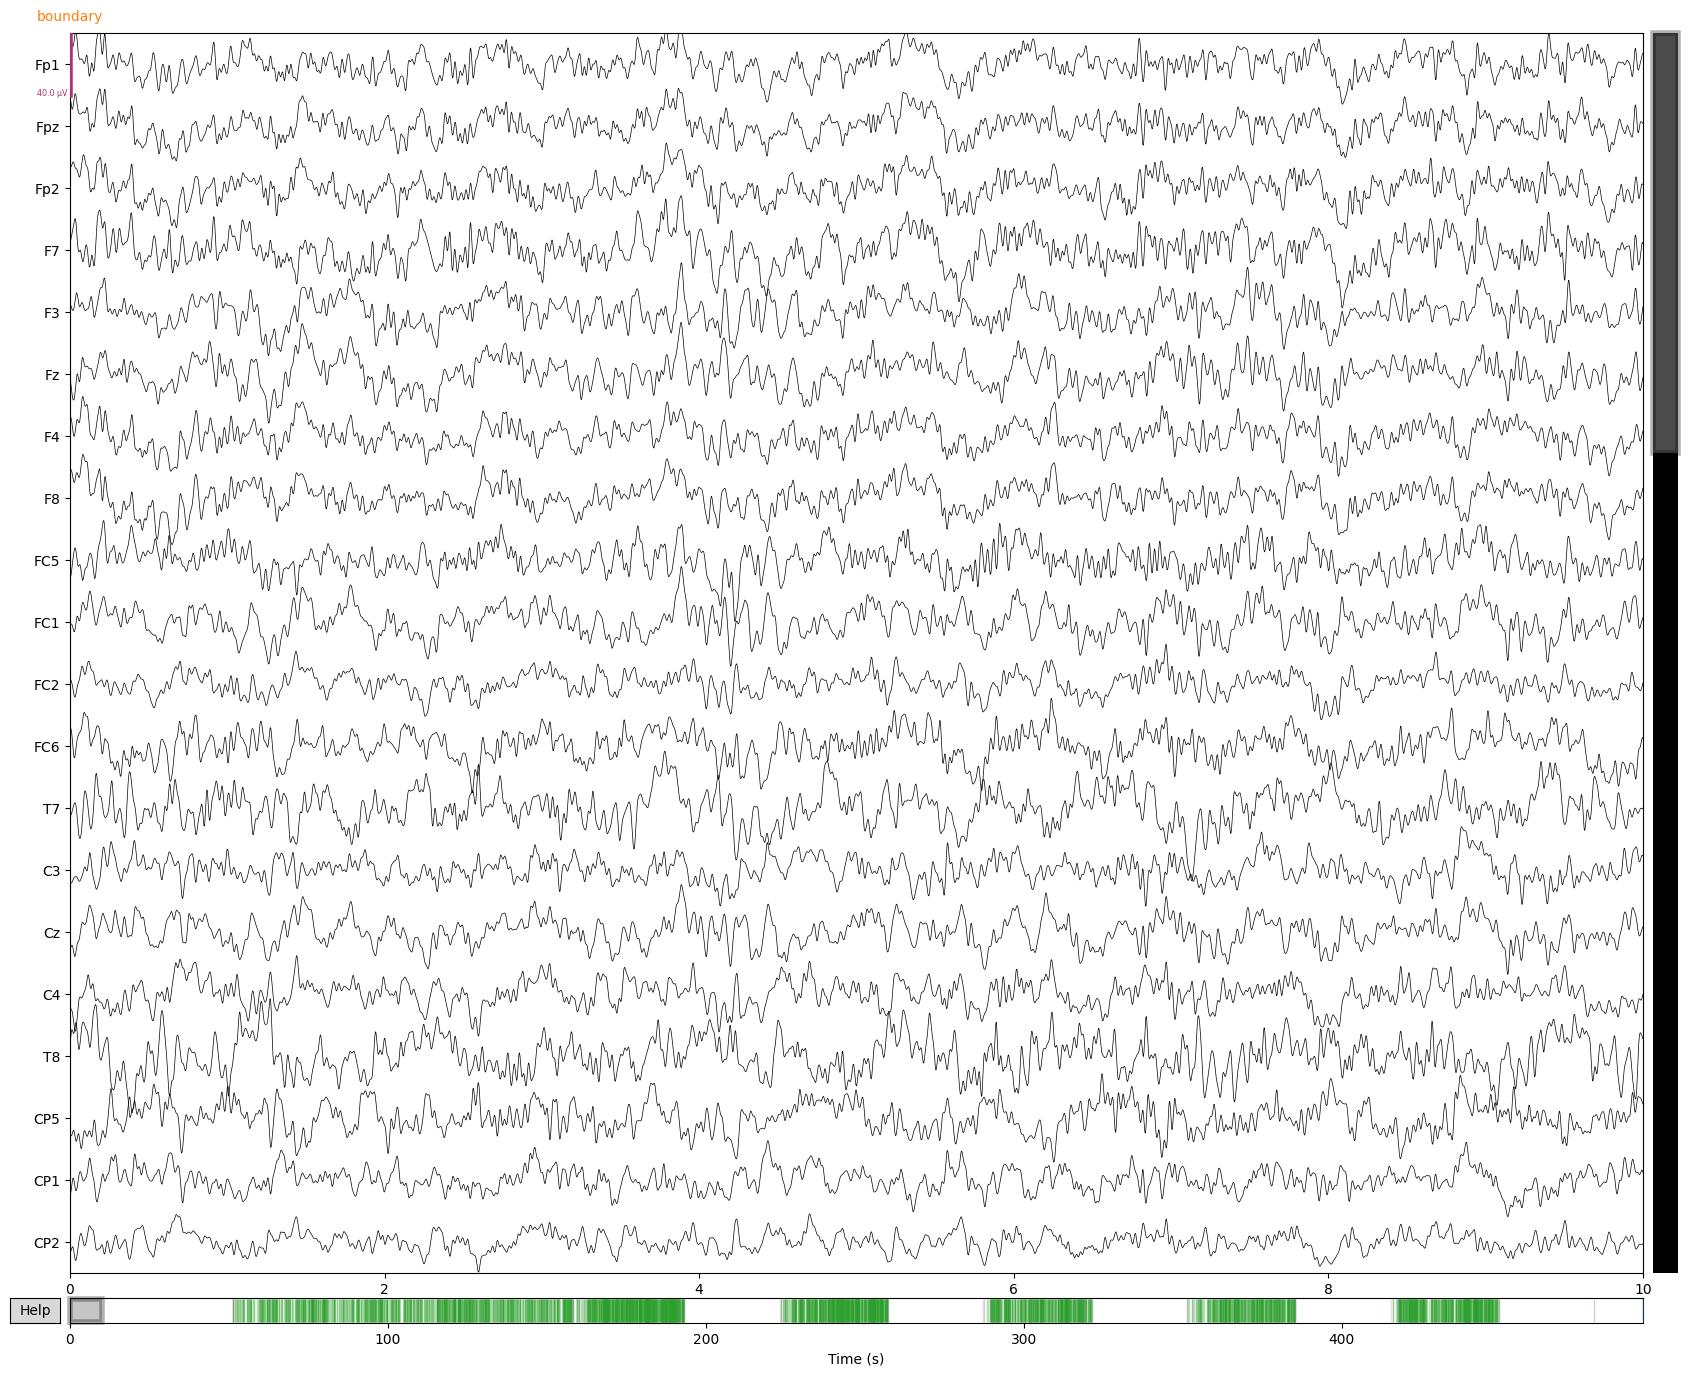

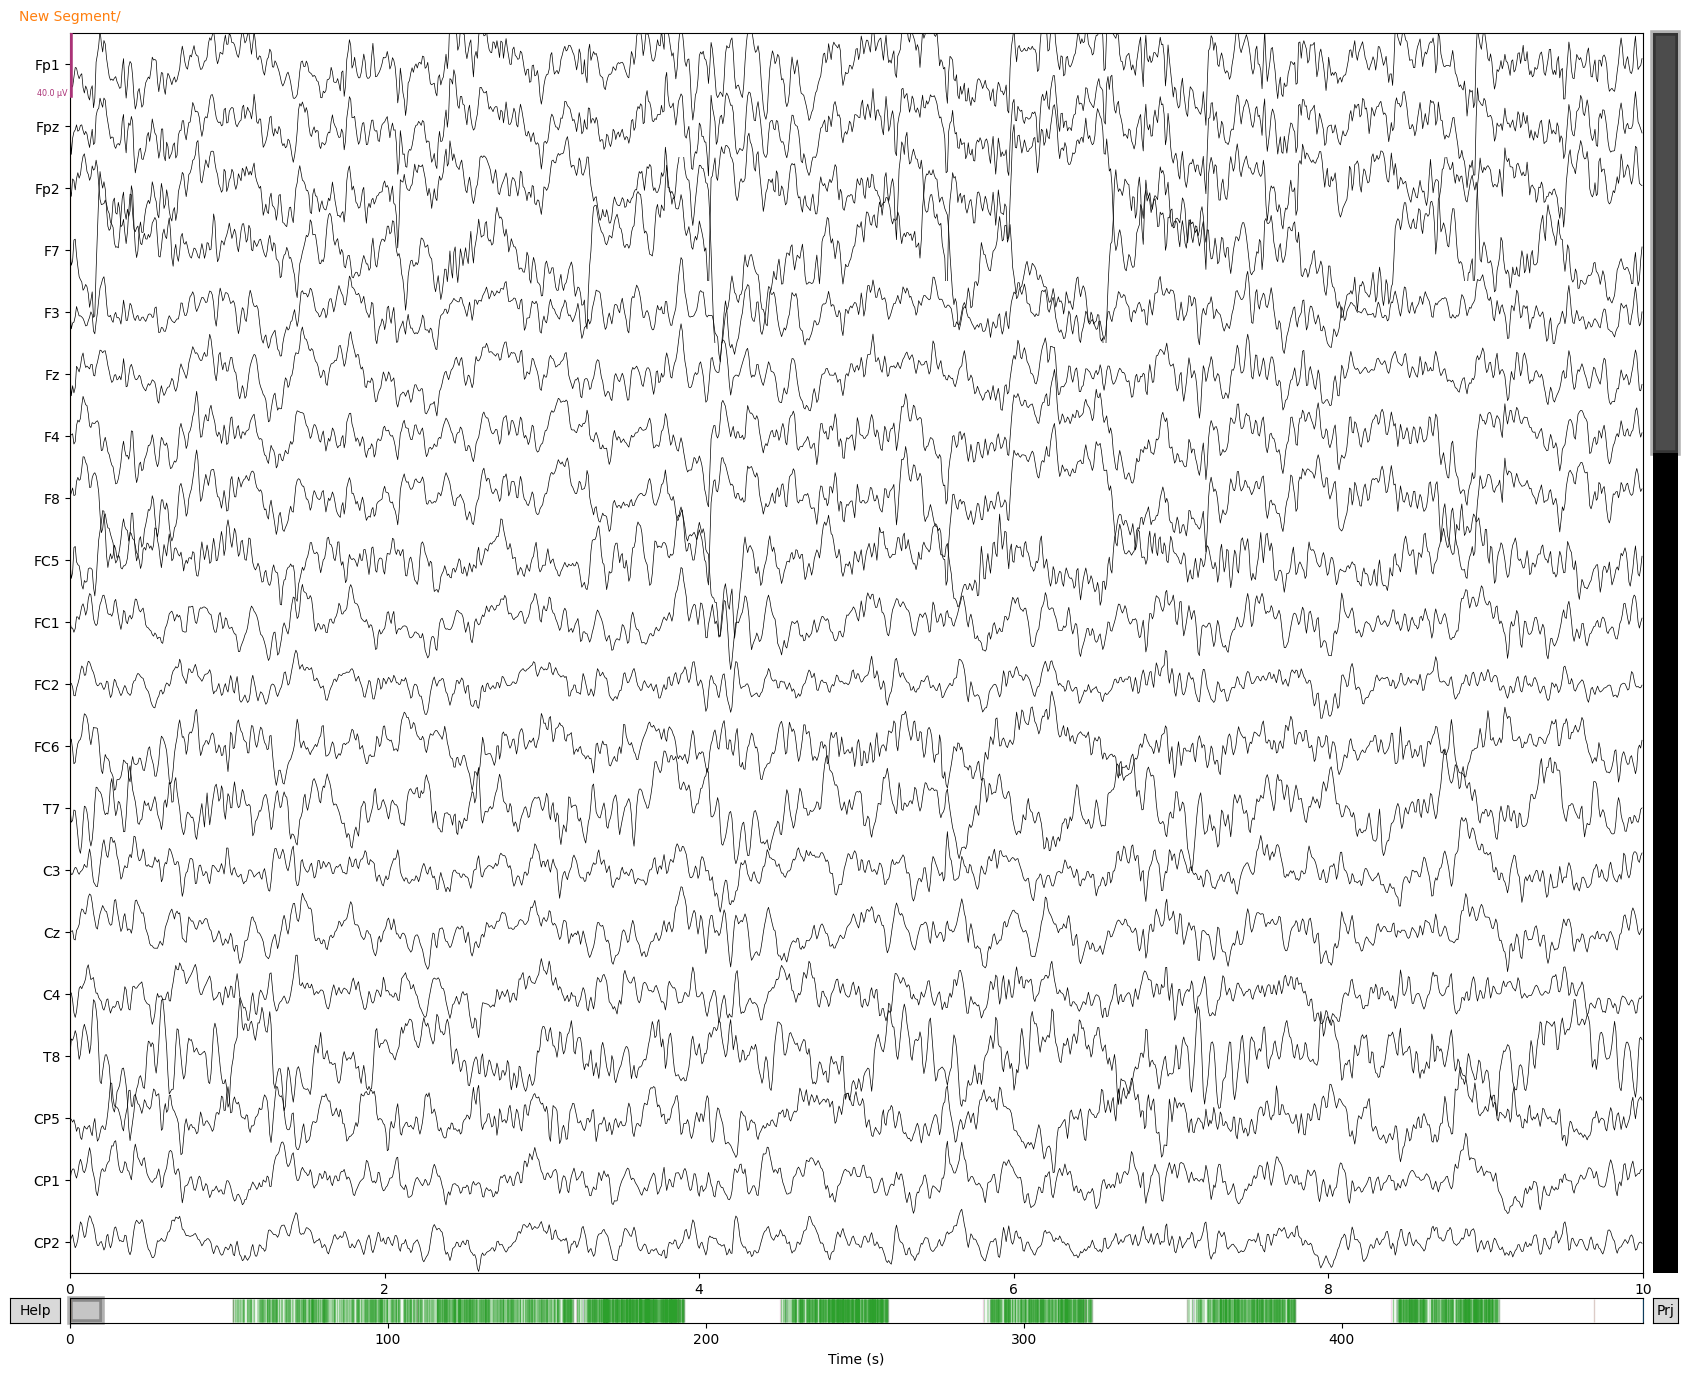

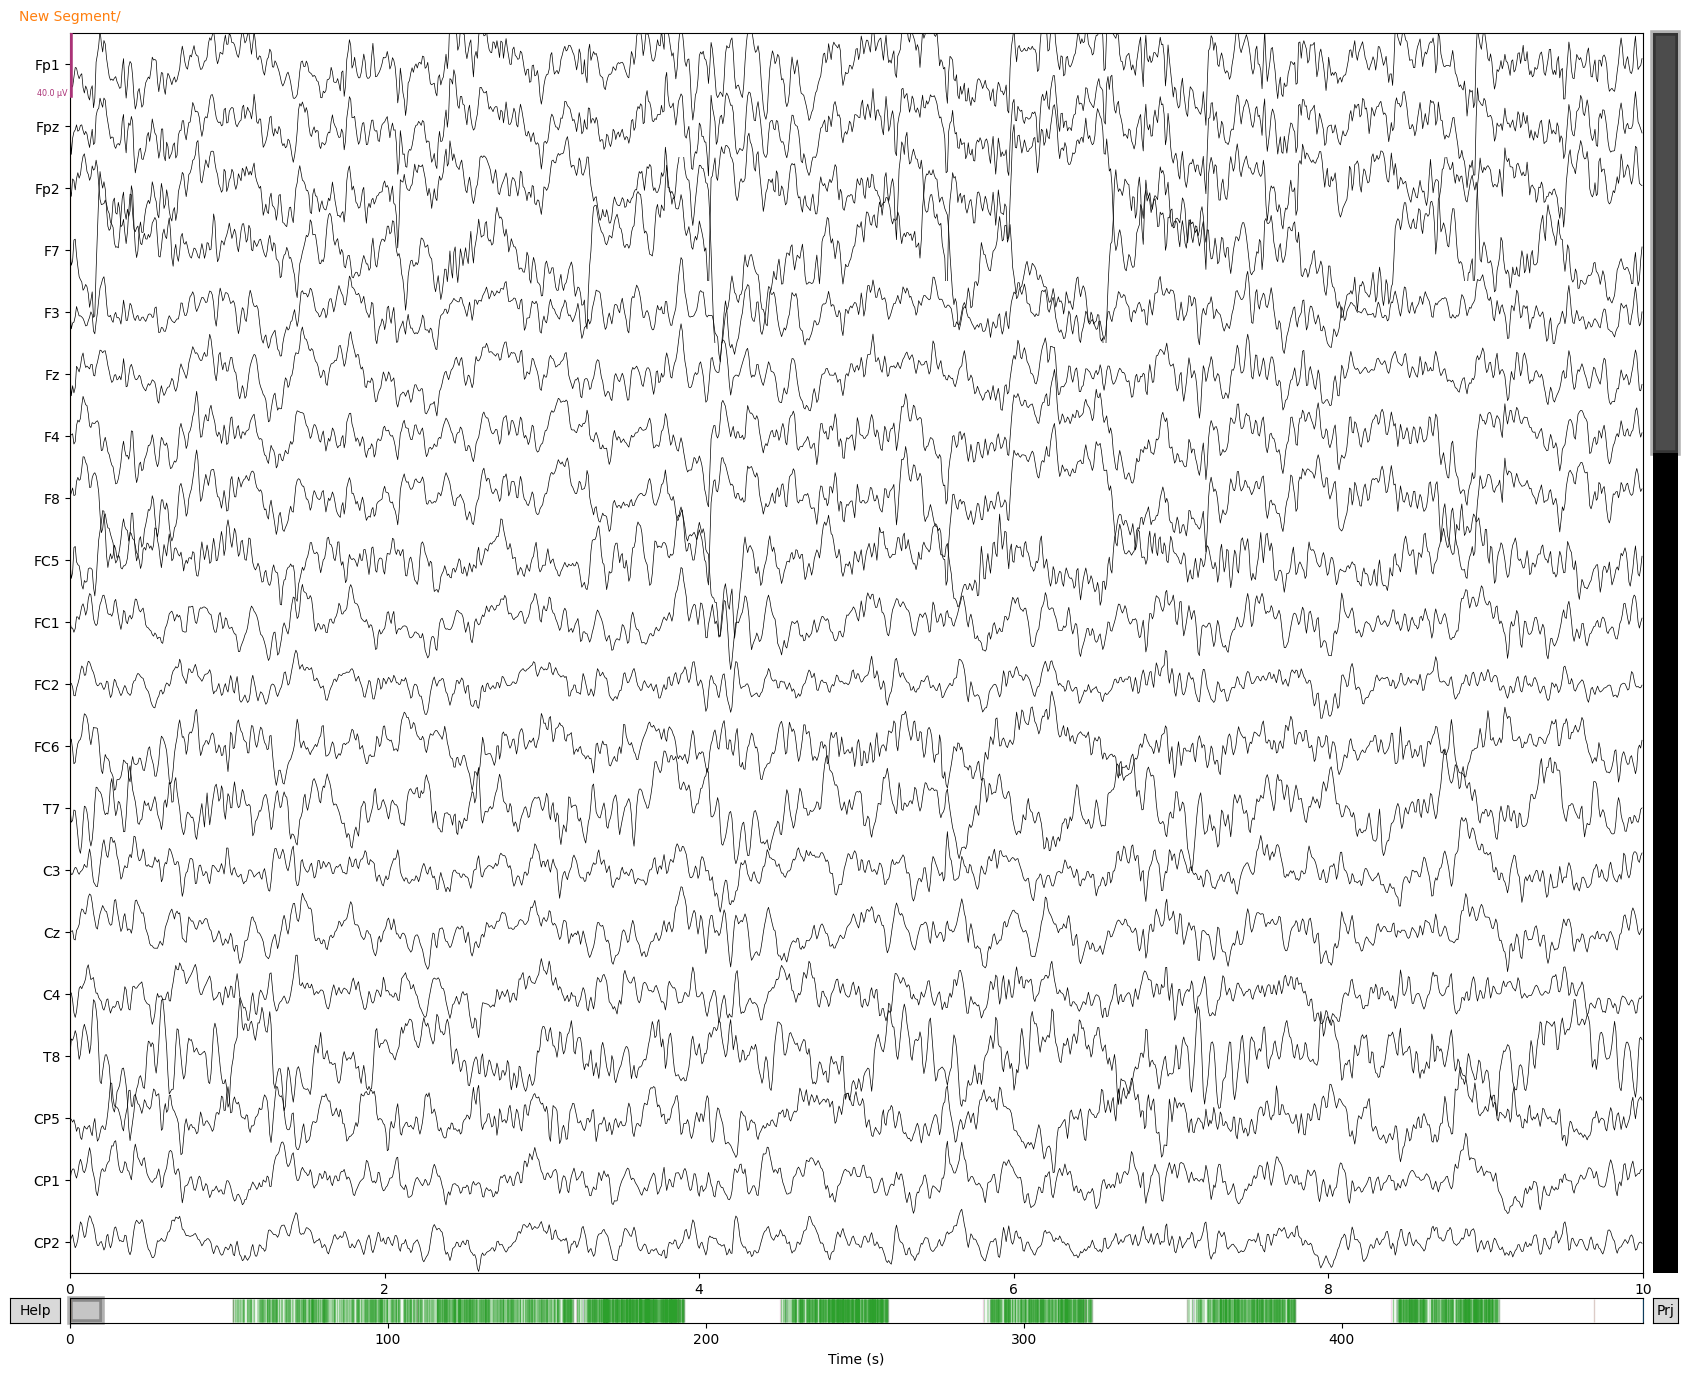

In [299]:
%matplotlib inline
raw_fix.plot()
raw_clean.plot()
raw.plot()